In [135]:
import torch
from model import Encoder, CharTokenizer
from trainer import train
from data import get_datasets
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.cuda.current_device()
else:
    device = 'cpu'

print(device)

0


In [2]:
train_dataset, test_dataset = get_datasets()

Loading preprocessed train data...


In [41]:
!ls ckpts/

model_WSIZE_1024_20240423_2022.pt	 model_WSIZE_256_woCNN_20240429_1304.pt
model_WSIZE_1024_noise_20240425_1333.pt  model_WSIZE_512_20240423_2022.pt
model_WSIZE_1024_raw_20240429_1200.pt	 model_WSIZE_512_noise_20240425_1333.pt
model_WSIZE_128_20240423_1651.pt	 model_WSIZE_512_raw_20240429_1200.pt
model_WSIZE_128_20240423_2022.pt	 model_WSIZE_512_woCNN_20240429_1303.pt
model_WSIZE_128_noise_20240425_1333.pt	 model_WSIZE_64_20240423_1651.pt
model_WSIZE_128_raw_20240429_1200.pt	 model_WSIZE_64_20240423_2007.pt
model_WSIZE_128_woCNN_20240429_1304.pt	 model_WSIZE_64_20240423_2022.pt
model_WSIZE_256_20240423_1649.pt	 model_WSIZE_64_noise_20240425_1333.pt
model_WSIZE_256_20240423_2022.pt	 model_WSIZE_64_raw_20240429_1200.pt
model_WSIZE_256_noise_20240425_1333.pt	 model_WSIZE_64_woCNN_20240429_1303.pt
model_WSIZE_256_raw_20240429_1200.pt


In [57]:
my_tokenizer = CharTokenizer()

WSIZE = 512

my_model = Encoder(WSIZE, 37+1, 256, num_blocks=4, n_heads=8, dropout=0.0, all_activations=True) # window_size, vocab_size, embed_size

my_model.load_state_dict(torch.load("./ckpts/model_WSIZE_512_20240423_2022.pt"))

my_model.to(device)

# optimizer = torch.optim.Adam(my_model.parameters(), weight_decay=0.001)
# loss_func = torch.nn.CrossEntropyLoss()

# train(my_model, train_dataset, optimizer, loss_func, my_tokenizer, batch_size=16, n_epochs=10, device=device, mask_ratio=0.0)

Encoder(
  (word_embedding): Embedding(38, 256)
  (pos_embedding): Embedding(512, 256)
  (blocks): ModuleList(
    (0): TransformerBlock(
      (cnn): CharCNN(
        (c3): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (c5): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
        (c7): Conv1d(256, 256, kernel_size=(7,), stride=(1,), padding=(3,))
        (c9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
        (c11): Conv1d(256, 256, kernel_size=(11,), stride=(1,), padding=(5,))
        (c3sep): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (c5sep): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (c7sep): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (c9sep): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (c11sep): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (c3_prime): Conv1d(1280, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (leakyrelu1): LeakyReLU(negative_slope=0.

In [162]:
from utils import Subst_cipher, unigram_freq_decipher, CHAR_SPACE
from data import preprocess_str
from model import freq_encoder
from metrics import character_accuracy


def logitsToStr(tokenizer, logits):
    return ''.join(tokenizer.decode([int(i) for i in logits.argmax(-1)[0].cpu()]))


astring = """The Small Innovative Missions for Planetary Exploration ("SIMPLEx") program was intended as a program to select small, low-cost space missions to fly as secondary payloads on other NASA missions. As a ride-along mission on another launch, not a main mission, they were intended to have low cost and tolerate a higher level of risk than other NASA missions.

EscaPADE was originally selected from a competition to be a low-cost ride-along "mission of opportunity" to hitch a ride to Mars with the Psyche spacecraft, and drop off as the spacecraft made a fly-by of Mars. Thus, it had an anticipated launch cost of nearly nothing. However, the launch of the Psyche mission was delayed, which meant that when Psyche passes the orbit of Mars, Mars is no longer near the trajectory of Psyche. Rather than cancel the mission, NASA announced that it would go on a different launch vehicle, and requested bids from industry for the launch.

In February 2023, Blue Origin won the contract to launch the mission on the first flight of the New Glenn launch vehicle in September 2024, at a cost of ~$20 million.
"""

plain = preprocess_str(astring)[:WSIZE]

In [163]:
plain.__len__()

512

In [164]:
ciphertext = Subst_cipher().encrypt(plain)
''.join(ciphertext)

'ad1 qk6ss 3nn5p6a3p1 k3qq35nq 457 9s6n1a67c 1y9s576a35n q3k9s1y 975876k i6q 3na1nt1t 6q 6 975876k a5 q1s1ja qk6ss s5ij5qa q96j1 k3qq35nq a5 4sc 6q q1j5nt67c 96cs56tq 5n 5ad17 n6q6 k3qq35nq 6q 6 73t16s5n8 k3qq35n 5n 6n5ad17 s6znjd n5a 6 k63n k3qq35n ad1c i171 3na1nt1t a5 d6p1 s5i j5qa 6nt a5s176a1 6 d38d17 s1p1s 54 73qm ad6n 5ad17 n6q6 k3qq35nq1qj696t1 i6q 57383n6ssc q1s1ja1t 475k 6 j5k91a3a35n a5 x1 6 s5ij5qa 73t16s5n8 k3qq35n 54 59957azn3ac a5 d3ajd 6 73t1 a5 k67q i3ad ad1 9qcjd1 q96j1j764a 6nt t759 544 6q'

In [165]:
ciphertext_batch = torch.tensor([freq_encoder(my_tokenizer.encode(ciphertext))], dtype=torch.long).to(device)
# ciphertext_batch = torch.tensor([my_tokenizer.encode(ciphertext)], dtype=torch.long).to(device)
logits, activations = my_model(ciphertext_batch)

In [166]:
plain_pred = logitsToStr(my_tokenizer, logits)
plain_pred

'the smarr innovative missions for pranetary exproration simprex program was intended as a program to serept smarr rowpost spape missions to fly as sepondary pagroads on other nasa missions as a ridearong mission on another raunph not a main mission they were intended to have row post and torerate a higher rever of risk than other nasa missionsespapade was originarly serepted from a pompetition to je a rowpost ridearong mission of opportunity to hitph a ride to mars with the psgphe spapepraft and drop off as'

In [167]:
plain

'the small innovative missions for planetary exploration simplex program was intended as a program to select small lowcost space missions to fly as secondary payloads on other nasa missions as a ridealong mission on another launch not a main mission they were intended to have low cost and tolerate a higher level of risk than other nasa missionsescapade was originally selected from a competition to be a lowcost ridealong mission of opportunity to hitch a ride to mars with the psyche spacecraft and drop off as'

In [168]:
character_accuracy(plain, plain_pred)

0.927734375

In [227]:
import difflib

def char_level_html_diff(text1, text2):
    assert len(text1) == len(text2), "Strings must be of the same length"

    result = []
    for char1, char2 in zip(text1, text2):
        if char1 == char2:
            result.append(f"<span>{char1}</span>")
        else:
            result.append(f"<span style='background-color: #EF9A9A;'>{char2}</span>")
    return "".join(result)

diff_html = char_level_html_diff(plain, plain_pred)
with open('diff.html', 'w') as f:
    f.write(diff_html)

In [170]:
from utils import unigram_freq_decipher

unigram_freq_decipher(ciphertext)

'odi althh nrrebtonbi lnaanera fes chtriotsg iychestoner anlchiy csewstl pta nroirmim ta t csewstl oe aihiuo althh hepueao actui lnaanera oe fhg ta aiuermtsg ctghetma er eodis rtat lnaanera ta t snmitherw lnaaner er treodis htvrud reo t ltnr lnaaner odig pisi nroirmim oe dtbi hep ueao trm oehistoi t dnwdis hibih ef snak odtr eodis rtat lnaaneraiautctmi pta esnwnrthhg aihiuoim fsel t uelciononer oe 1i t hepueao snmitherw lnaaner ef eccesovrnog oe dnoud t snmi oe ltsa pnod odi cagudi actuiustfo trm msec eff ta'

In [172]:
character_accuracy(plain, unigram_freq_decipher(ciphertext))

0.18359375

In [173]:
activations[0].shape

torch.Size([1, 512, 256])

In [174]:
logitsToStr(my_tokenizer, my_model.output(activations[4].to(device)))

'the smarr innovative missions for pranetary exproration simprex program was intended as a program to serept smarr rowpost spape missions to fly as sepondary pagroads on other nasa missions as a ridearong mission on another raunph not a main mission they were intended to have row post and torerate a higher rever of risk than other nasa missionsespapade was originarly serepted from a pompetition to je a rowpost ridearong mission of opportunity to hitph a ride to mars with the psgphe spapepraft and drop off as'

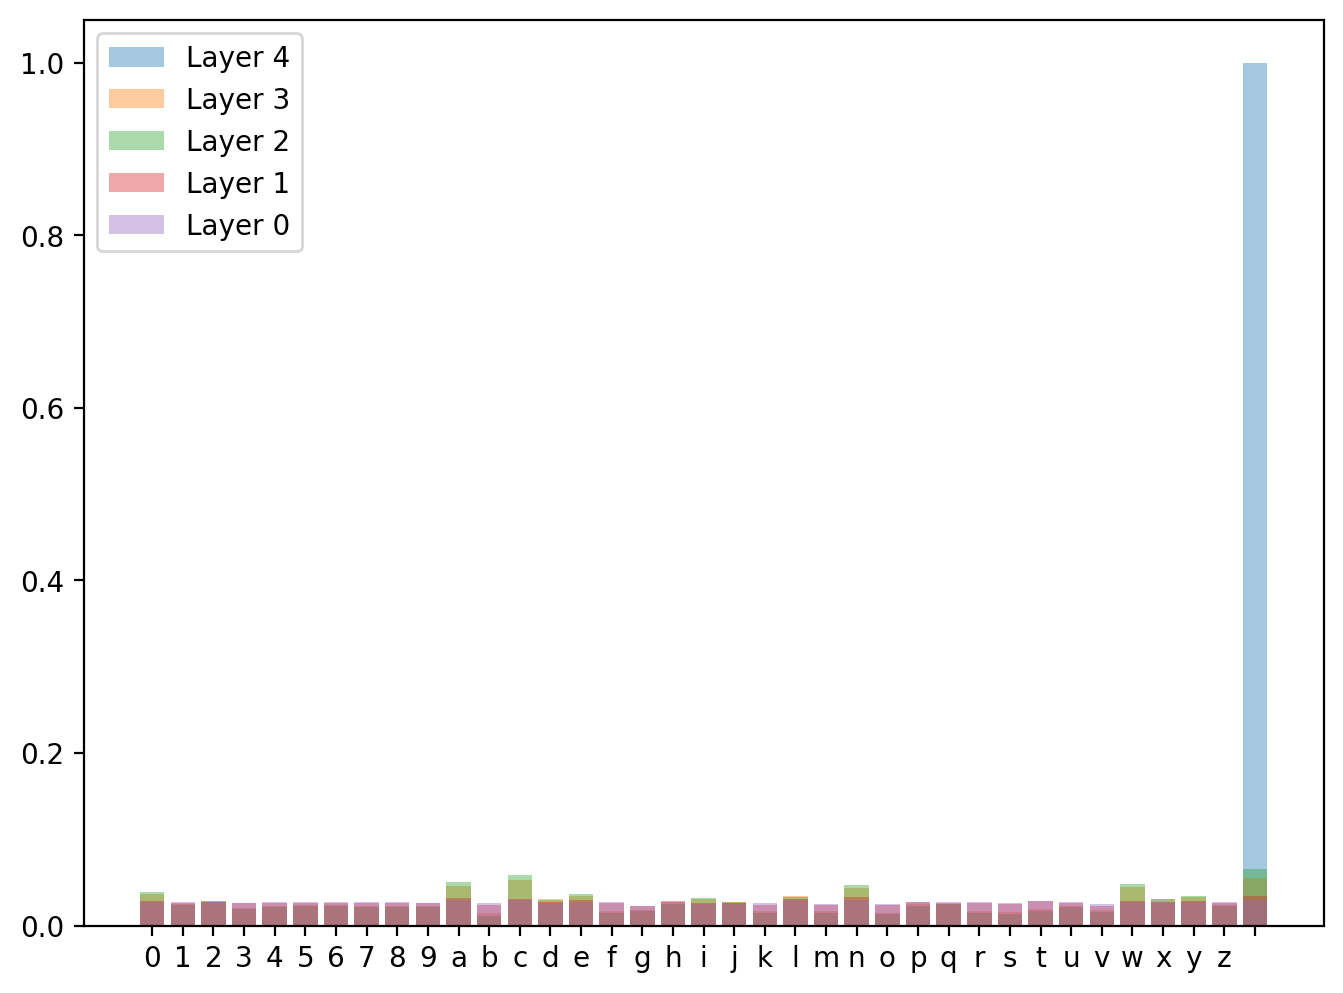

In [208]:
POSIDX=9

plt.figure(figsize=(8,6), dpi=200)

for i in range(4,-1,-1):
    plt.bar(CHAR_SPACE, torch.softmax(my_model.output(activations[i].to(device)).detach().cpu()[0][POSIDX][:len(CHAR_SPACE)], -1), label=f"Layer {i}", alpha=0.4)

plt.legend()
plt.show()

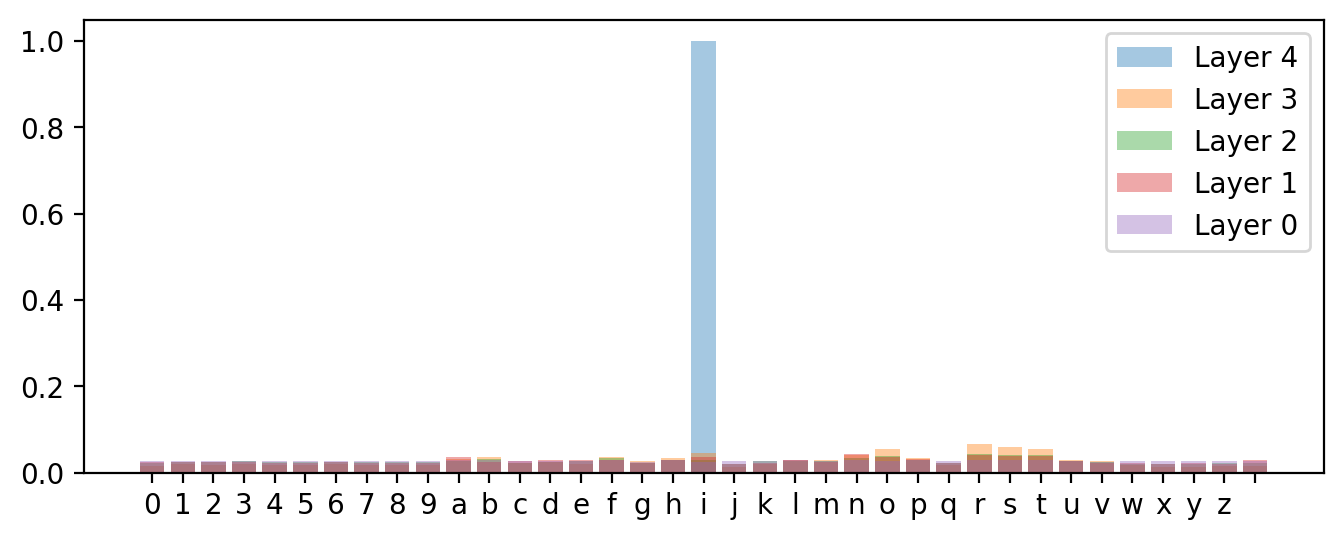

In [226]:
POSIDX=10

plt.figure(figsize=(8,3), dpi=200)

for i in range(4,-1,-1):
    plt.bar(CHAR_SPACE, torch.softmax(my_model.output(activations[i].to(device)).detach().cpu()[0][POSIDX][:len(CHAR_SPACE)], -1), label=f"Layer {i}", alpha=0.4)

plt.legend()
plt.show()